<a href="https://colab.research.google.com/github/aekanun2020/AdvancedStat/blob/main/2025_ih_EGAT_ARIMA_ENG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
# LAB 3: Exponential Smoothing and ARIMA/SARIMA Models for Time Series Analysis in Electrical Systems

## Part 1: Creating Simulated Electricity Production Data
--------------------------------------------------
Creating hourly electricity production simulation data...

Sample data:
                     power_output  hour  day  dayofweek  month  year
2020-01-01 00:00:00   1009.934283     0    1          2      1  2020
2020-01-01 01:00:00   1023.271181     1    1          2      1  2020
2020-01-01 02:00:00   1063.265071     2    1          2      1  2020
2020-01-01 03:00:00   1101.641355     3    1          2      1  2020
2020-01-01 04:00:00   1050.656156     4    1          2      1  2020

Basic statistics:
count    26305.000000
mean      1478.602711
std        282.083079
min        780.879629
25%       1251.327148
50%       1424.011936
75%       1677.884459
max       2564.263511
Name: power_output, dtype: flo

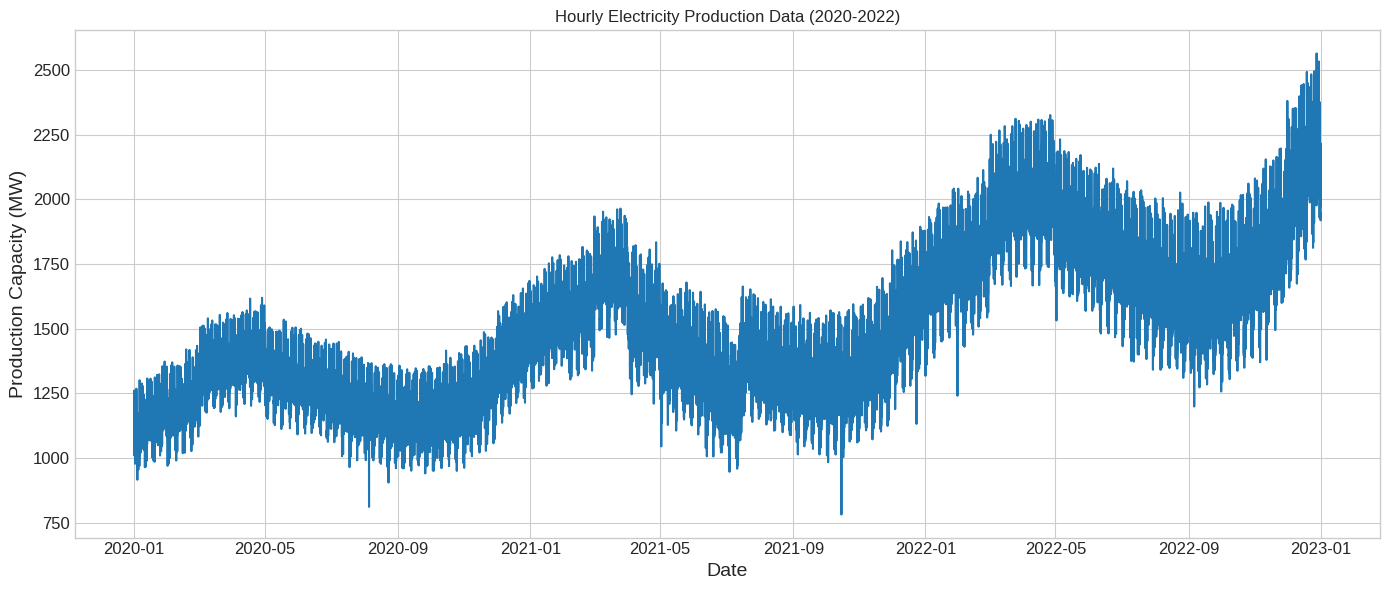

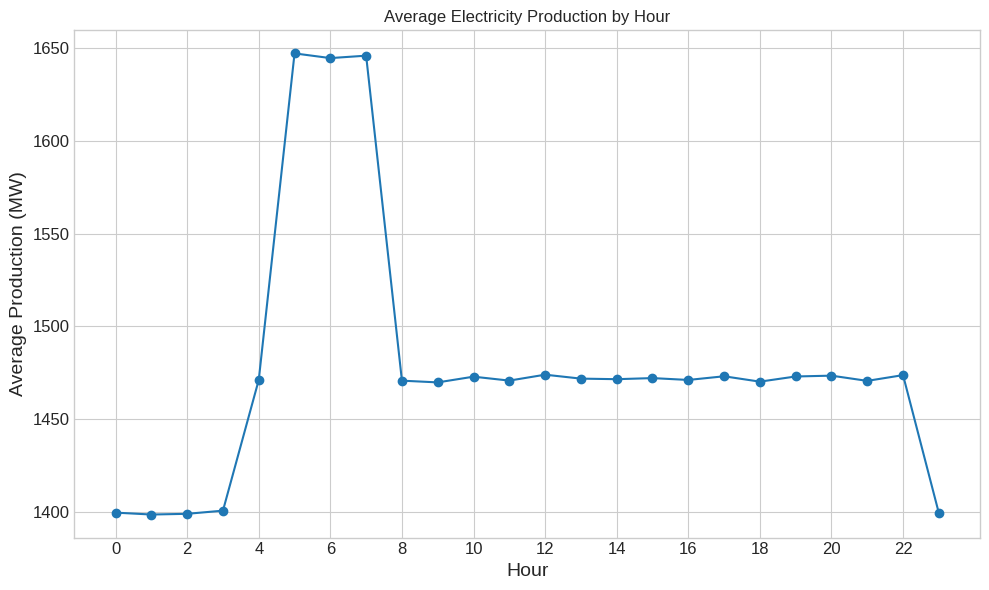

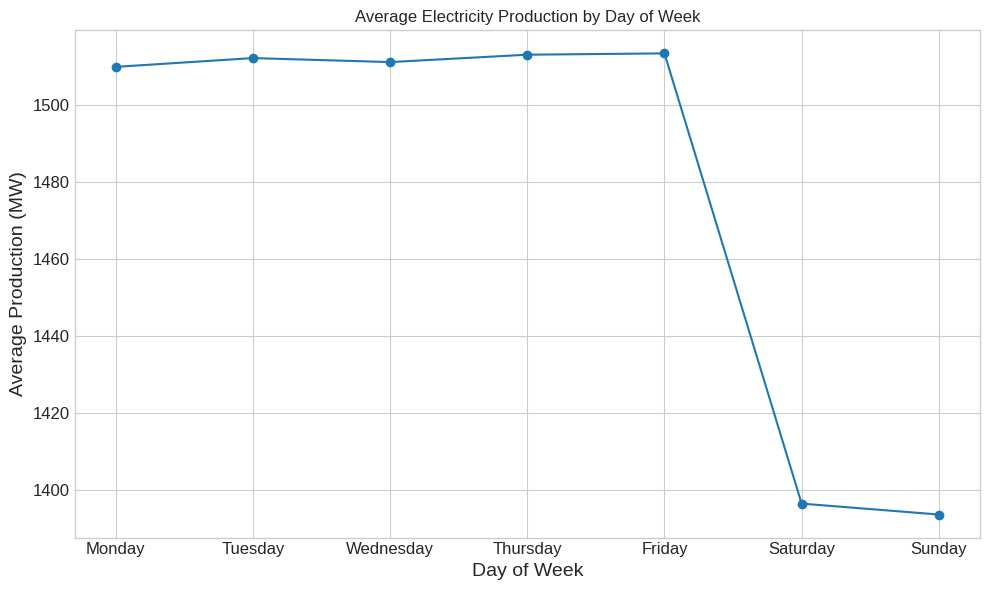

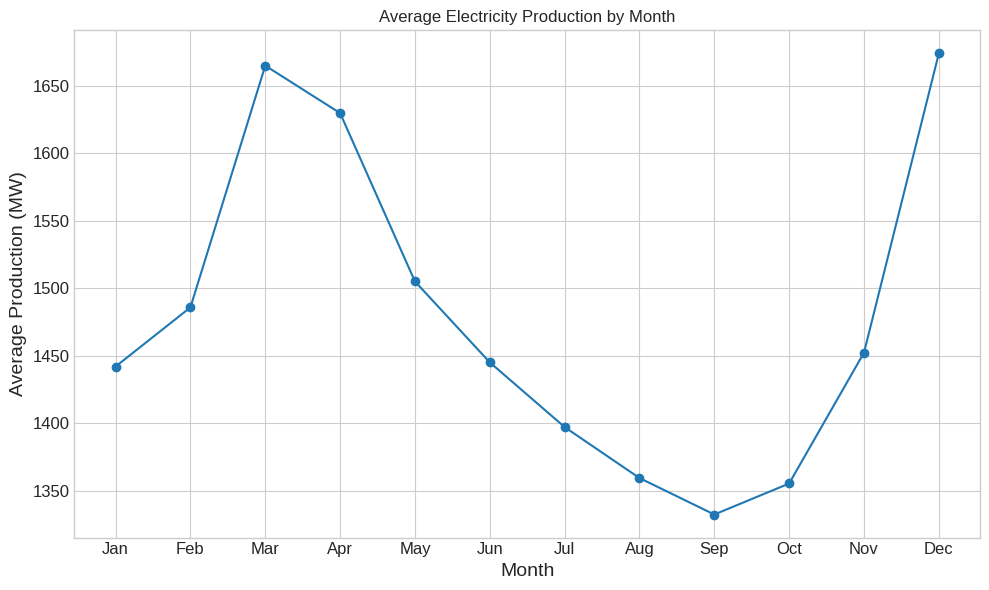


Created daily data by resampling from hourly data: 1097 days


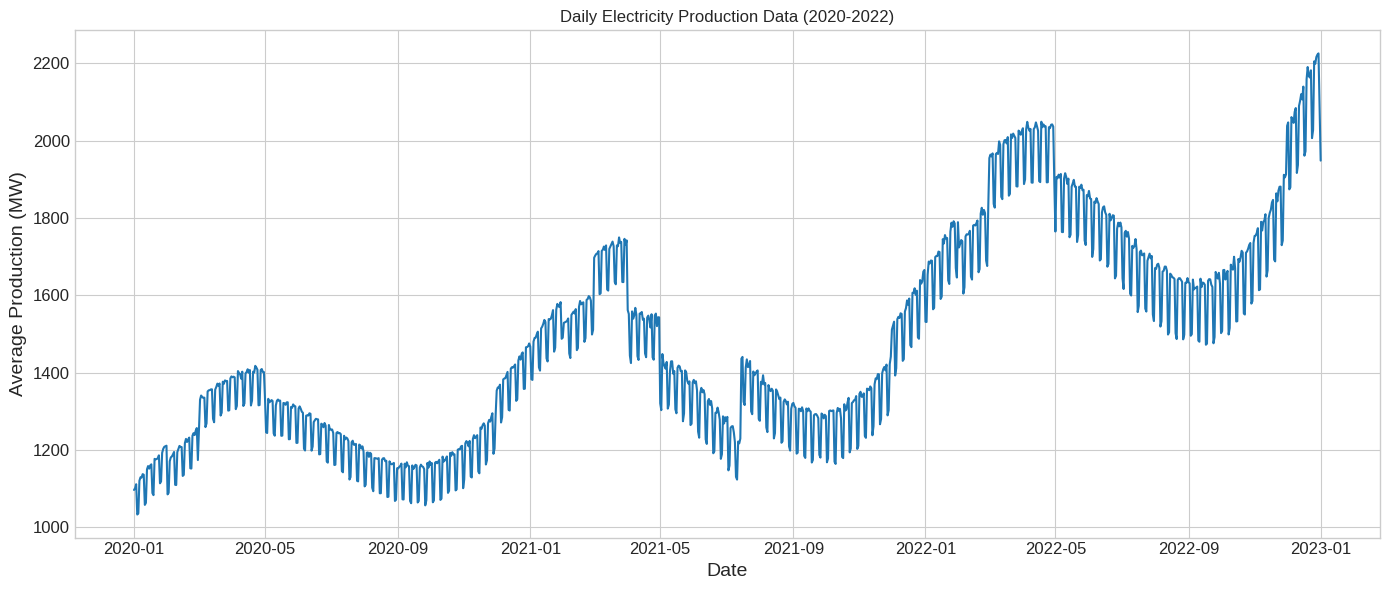

In [1]:
# -*- coding: utf-8 -*-
"""2025_ih_EGAT_ARIMA.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/github/aekanun2020/AdvancedStat/blob/main/hands-on-3-ARIMA/2025_ih_EGAT_ARIMA.ipynb
"""

# Lab 3: Exponential Smoothing and ARIMA/SARIMA Models
# for Time Series Analysis in Electrical Systems

# Install necessary packages
!pip install pandas numpy matplotlib seaborn statsmodels pmdarima scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta

# Turn off warnings
warnings.filterwarnings("ignore")

# Set graph style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Set seed for reproducibility
np.random.seed(42)

print("# LAB 3: Exponential Smoothing and ARIMA/SARIMA Models for Time Series Analysis in Electrical Systems")
print("=" * 100)

# ---------------------------------------------------------------------------------
# Part 1: Create simulated data continuing from Lab 1 and Lab 2
# ---------------------------------------------------------------------------------
print("\n## Part 1: Creating Simulated Electricity Production Data")
print("-" * 50)

def generate_simulated_power_data(start_date='2020-01-01', end_date='2023-01-01', hourly=True):
    """
    Create simulated electricity production data consisting of 4 main components:
    1. Trend: 3% annual growth with mid-period adjustment
    2. Seasonality: Yearly, daily, weekly
    3. Cyclical: Long-term pattern of about 3 years
    4. Irregular: Random fluctuations and special events
    """

    # Set time period
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    if hourly:
        # Hourly data
        date_range = pd.date_range(start=start, end=end, freq='H')
    else:
        # Daily data
        date_range = pd.date_range(start=start, end=end, freq='D')

    df = pd.DataFrame(index=date_range)
    n_periods = len(df)

    # 1. Trend - 3% annual growth with mid-period adjustment
    base_power = 1000  # Base production capacity (MW)

    # Create non-linear trend
    trend = np.linspace(0, 1, n_periods)
    # Add mid-period reduction
    midpoint = n_periods // 2
    adjustment = np.sin(np.linspace(0, np.pi, n_periods)) * 0.1
    trend = trend * (1 + 0.03) - adjustment  # 3% annual growth with mid-period adjustment
    trend = base_power * (1 + trend)

    # 2. Seasonality
    # 2.1 Annual seasonality
    if hourly:
        annual_cycle = 365 * 24  # Hours in a year
    else:
        annual_cycle = 365  # Days in a year

    annual_seasonality = np.sin(2 * np.pi * np.arange(n_periods) / annual_cycle) * 0.15
    # Adjust higher in March-April and December
    month_index = pd.Series(df.index.month)
    spring_mask = month_index.isin([3, 4])
    winter_mask = month_index.isin([12, 1])
    annual_seasonality += spring_mask.values * 0.07 + winter_mask.values * 0.05

    # 2.2 Daily seasonality (for hourly data)
    if hourly:
        daily_seasonality = np.sin(2 * np.pi * np.arange(n_periods) % 24 / 24) * 0.1
        # Higher from 5-7 AM and lower at night
        hour_index = pd.Series(df.index.hour)
        peak_hours_mask = hour_index.isin([5, 6, 7])
        night_hours_mask = hour_index.isin([23, 0, 1, 2, 3])
        daily_seasonality += peak_hours_mask.values * 0.12 - night_hours_mask.values * 0.05
    else:
        daily_seasonality = 0

    # 2.3 Weekly seasonality
    weekday = df.index.dayofweek
    weekend_mask = (weekday >= 5)  # 5 = Saturday, 6 = Sunday
    weekly_seasonality = np.where(weekend_mask, -0.08, 0)  # 8% reduction on weekend

    # 3. Cyclical - 3-year pattern
    if hourly:
        cycle_length = 3 * 365 * 24  # 3 years in hours
    else:
        cycle_length = 3 * 365  # 3 years in days

    cyclical = np.sin(2 * np.pi * np.arange(n_periods) / cycle_length) * 0.08

    # 4. Irregular component
    # 4.1 General volatility
    noise = np.random.normal(0, 0.02, n_periods)

    # 4.2 Special events (maintenance, emergencies)
    special_events = np.zeros(n_periods)

    # Create maintenance period causing reduced production (April-July 2021)
    if hourly:
        maintenance_start = pd.to_datetime('2021-04-01')
        maintenance_end = pd.to_datetime('2021-07-15')
        for i, dt in enumerate(df.index):
            if maintenance_start <= dt <= maintenance_end:
                # Reduce production during maintenance
                special_events[i] = -0.15 + np.random.normal(0, 0.03)
    else:
        maintenance_dates = pd.date_range(start='2021-04-01', end='2021-07-15')
        maintenance_mask = df.index.isin(maintenance_dates)
        special_events[maintenance_mask] = -0.15 + np.random.normal(0, 0.03, sum(maintenance_mask))

    # Create emergency events causing significant reduction on some days
    n_events = 10
    event_indices = np.random.choice(range(n_periods), n_events, replace=False)
    special_events[event_indices] = -0.3 + np.random.normal(0, 0.05, n_events)

    # Combine all components
    power_output = trend * (1 + annual_seasonality + daily_seasonality + weekly_seasonality + cyclical + noise + special_events)

    # Create DataFrame
    df['power_output'] = power_output

    # Add classification columns
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek  # 0=Monday, 6=Sunday
    df['month'] = df.index.month
    df['year'] = df.index.year

    return df

# Create simulated data
print("Creating hourly electricity production simulation data...")
data = generate_simulated_power_data(start_date='2020-01-01', end_date='2023-01-01', hourly=True)

# Display first 5 rows
print("\nSample data:")
print(data.head())

# Display basic statistics
print("\nBasic statistics:")
print(data['power_output'].describe())

# Display data graph
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['power_output'])
plt.title('Hourly Electricity Production Data (2020-2022)')
plt.xlabel('Date')
plt.ylabel('Production Capacity (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display seasonal patterns
# By hour
hourly_avg = data.groupby('hour')['power_output'].mean()
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title('Average Electricity Production by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Production (MW)')
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.tight_layout()
plt.show()

# By day of week
daily_avg = data.groupby('dayofweek')['power_output'].mean()
plt.figure(figsize=(10, 6))
plt.plot(daily_avg.index, daily_avg.values, marker='o')
plt.title('Average Electricity Production by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Production (MW)')
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.tight_layout()
plt.show()

# By month
monthly_avg = data.groupby('month')['power_output'].mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Average Electricity Production by Month')
plt.xlabel('Month')
plt.ylabel('Average Production (MW)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Work with daily data
daily_data = data.resample('D').mean()
print(f"\nCreated daily data by resampling from hourly data: {daily_data.shape[0]} days")

# Display daily data
plt.figure(figsize=(14, 6))
plt.plot(daily_data.index, daily_data['power_output'])
plt.title('Daily Electricity Production Data (2020-2022)')
plt.xlabel('Date')
plt.ylabel('Average Production (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 2: Data Preparation and Dataset Splitting
--------------------------------------------------
Dataset dimensions:
Total data: 1097 days
Training set: 1065 days (Jan 2020 - Nov 2022)
Test set: 32 days (Dec 2022)


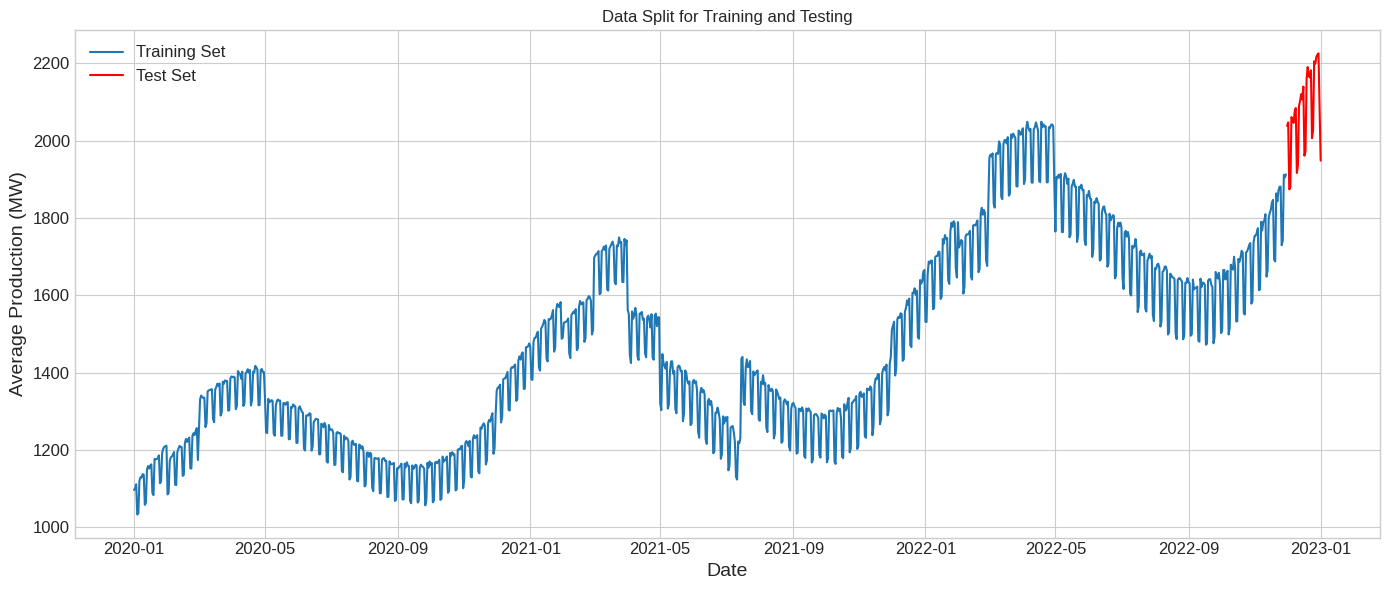

In [2]:
# ---------------------------------------------------------------------------------
# Part 2: Split data into training and testing sets
# ---------------------------------------------------------------------------------
print("\n## Part 2: Data Preparation and Dataset Splitting")
print("-" * 50)

# Prepare data for modeling
# Split data into training and testing sets
# Use data until the end of November 2022 for training and December 2022 for testing
train_data = daily_data[:'2022-11-30']
test_data = daily_data['2022-12-01':]

print(f"Dataset dimensions:")
print(f"Total data: {len(daily_data)} days")
print(f"Training set: {len(train_data)} days (Jan 2020 - Nov 2022)")
print(f"Test set: {len(test_data)} days (Dec 2022)")

# Display training and test set graphs
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['power_output'], label='Training Set')
plt.plot(test_data.index, test_data['power_output'], label='Test Set', color='red')
plt.title('Data Split for Training and Testing')
plt.xlabel('Date')
plt.ylabel('Average Production (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Function for calculating evaluation metrics
def calculate_metrics(actual, forecast):
    """Calculate various metrics for model evaluation"""
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Function for displaying forecast results
def plot_forecast_results(train_data, test_data, forecast, model_name):
    """Display forecast results compared to actual data"""
    plt.figure(figsize=(14, 6))
    plt.plot(train_data.index, train_data['power_output'], label='Training Data')
    plt.plot(test_data.index, test_data['power_output'], label='Actual Data', color='blue')
    plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
    plt.title(f'Forecast Results Using {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Average Production (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display metrics
    metrics = calculate_metrics(test_data['power_output'], forecast)
    print(f"\nModel Evaluation Results for {model_name}:")
    print(f"MAE: {metrics['MAE']:.2f} MW")
    print(f"RMSE: {metrics['RMSE']:.2f} MW")
    print(f"MAPE: {metrics['MAPE']:.2f}%")

    return metrics


## Part 3: Building Exponential Smoothing Models
--------------------------------------------------

### 3.1 Simple Exponential Smoothing (SES)
Suitable for data without trend and seasonality


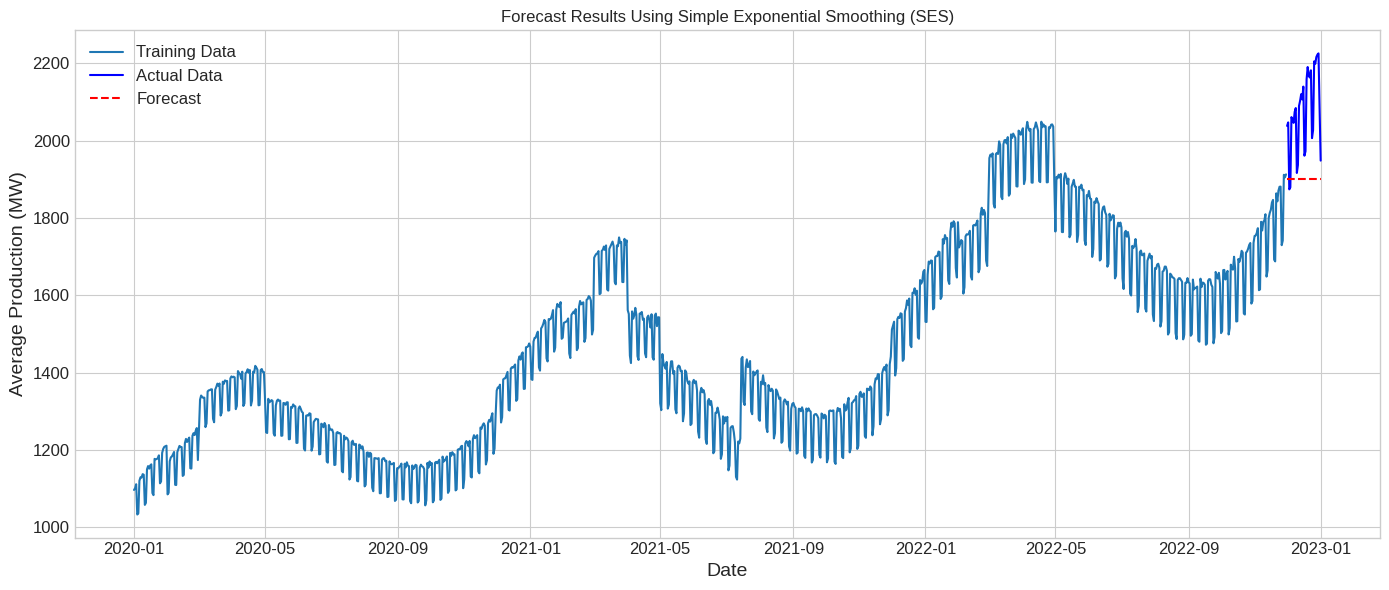


Model Evaluation Results for Simple Exponential Smoothing (SES):
MAE: 180.19 MW
RMSE: 203.86 MW
MAPE: 8.47%

### 3.2 Holt's Exponential Smoothing
Suitable for data with trend but without seasonality


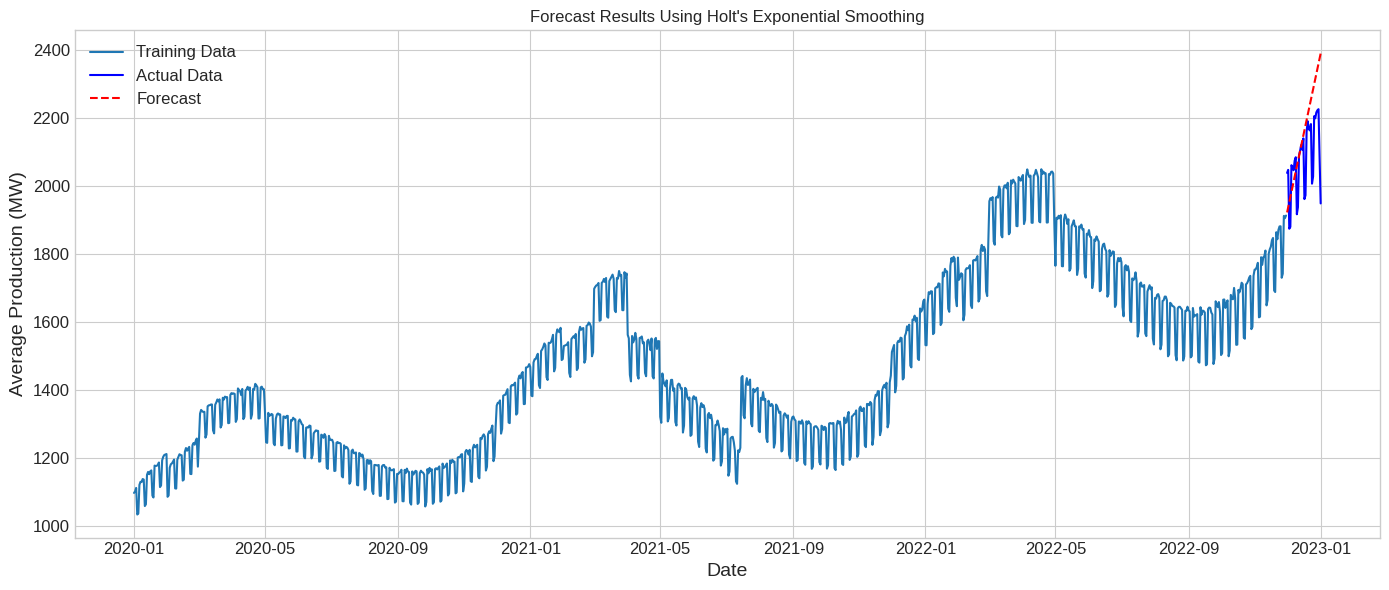


Model Evaluation Results for Holt's Exponential Smoothing:
MAE: 108.19 MW
RMSE: 145.14 MW
MAPE: 5.30%

### 3.3 Holt-Winters' Exponential Smoothing
Suitable for data with both trend and seasonality


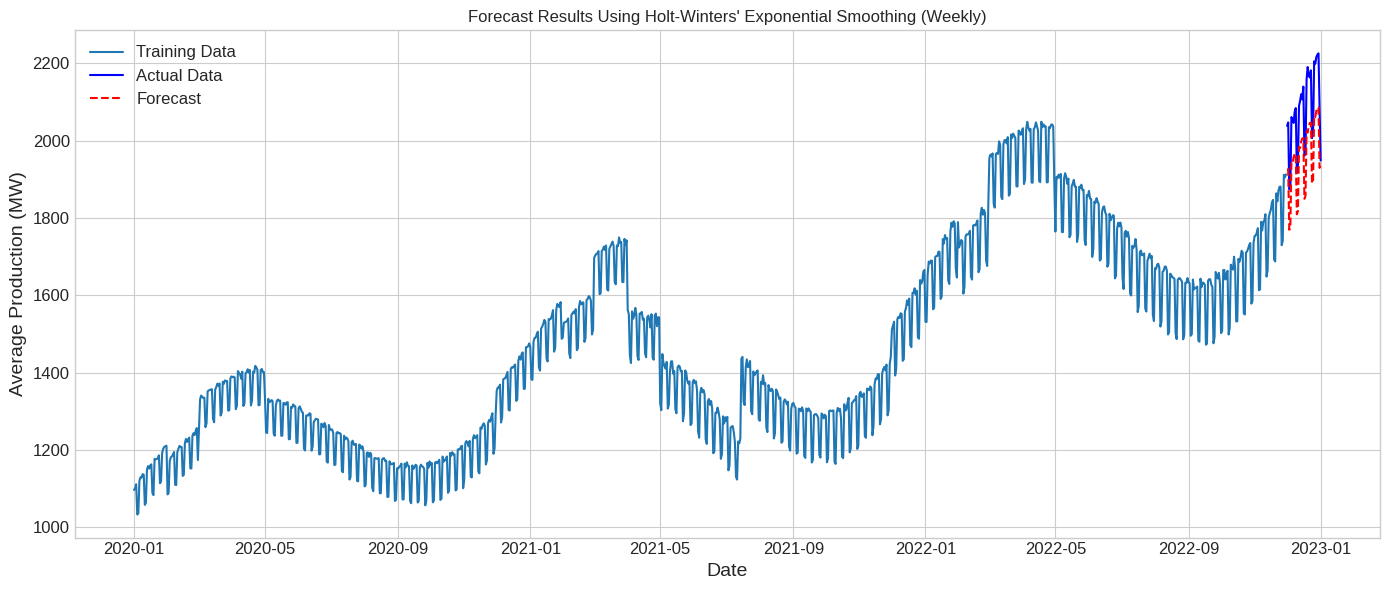


Model Evaluation Results for Holt-Winters' Exponential Smoothing (Weekly):
MAE: 119.38 MW
RMSE: 122.08 MW
MAPE: 5.72%

### 3.4 Holt-Winters' Exponential Smoothing (Monthly)


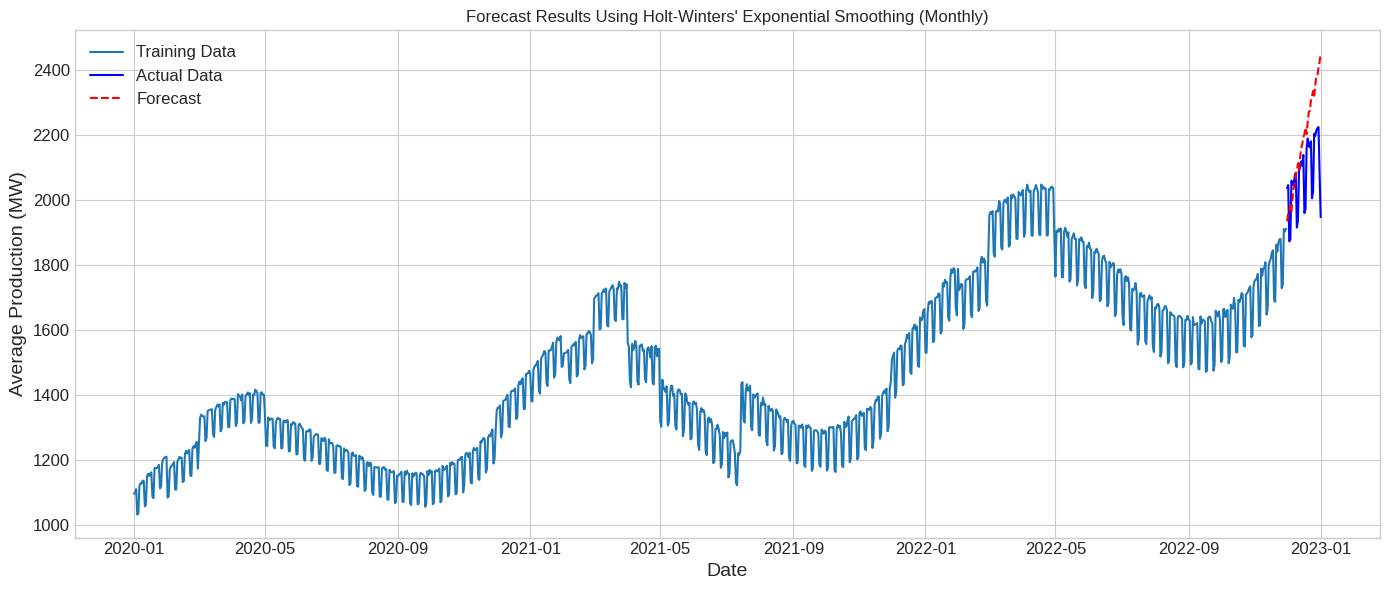


Model Evaluation Results for Holt-Winters' Exponential Smoothing (Monthly):
MAE: 134.25 MW
RMSE: 174.78 MW
MAPE: 6.55%

### 3.5 Performance Comparison of Exponential Smoothing Models

Performance Comparison Table for Exponential Smoothing Models:
           Simple Exponential Smoothing  Holt Exponential Smoothing  \
MAE (MW)                     180.191149                  108.186324   
RMSE (MW)                    203.855670                  145.141527   
MAPE (%)                       8.465903                    5.304502   

           Holt-Winters (Weekly)  Holt-Winters (Monthly)  
MAE (MW)              119.378856              134.250383  
RMSE (MW)             122.076245              174.776084  
MAPE (%)                5.722895                6.554507  


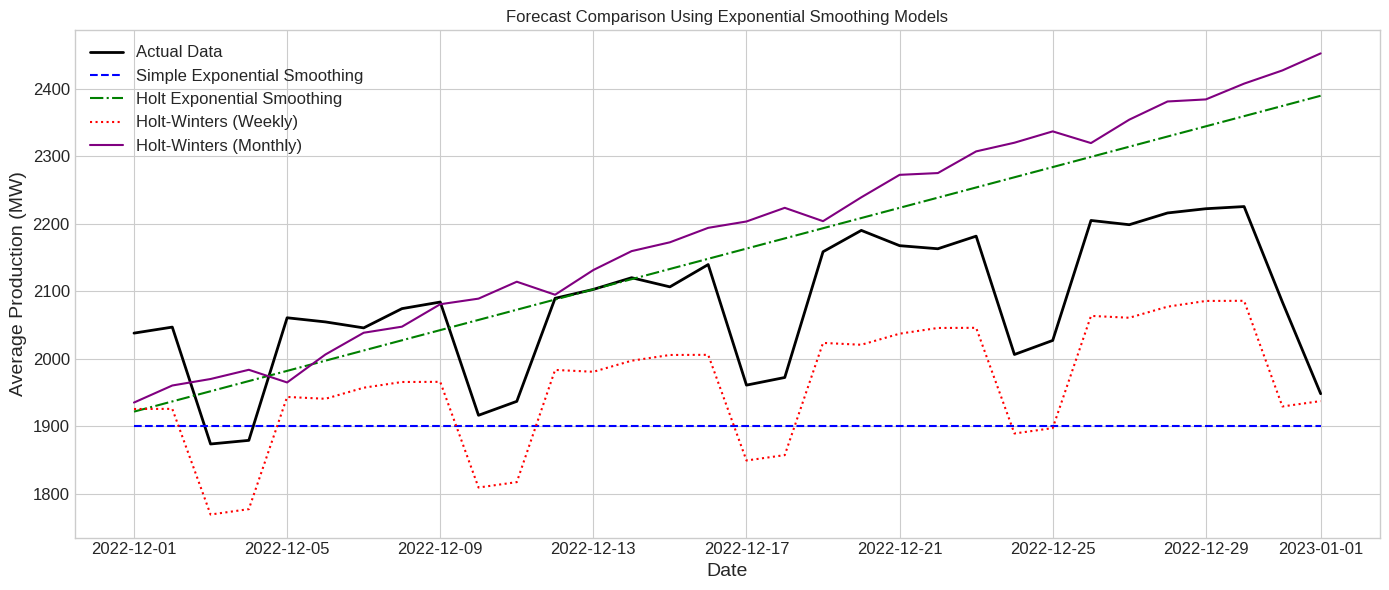

In [3]:
# ---------------------------------------------------------------------------------
# Part 3: Building Exponential Smoothing Models
# ---------------------------------------------------------------------------------
print("\n## Part 3: Building Exponential Smoothing Models")
print("-" * 50)

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 3.1 Simple Exponential Smoothing (SES)
print("\n### 3.1 Simple Exponential Smoothing (SES)")
print("Suitable for data without trend and seasonality")

# Build Simple Exponential Smoothing model
ses_model = SimpleExpSmoothing(train_data['power_output'])
ses_fit = ses_model.fit(smoothing_level=0.6, optimized=False)

# Forecast ahead
ses_forecast = ses_fit.forecast(len(test_data))

# Display forecast results
ses_metrics = plot_forecast_results(train_data, test_data, ses_forecast, 'Simple Exponential Smoothing (SES)')

# 3.2 Holt's Exponential Smoothing
print("\n### 3.2 Holt's Exponential Smoothing")
print("Suitable for data with trend but without seasonality")

# Build Holt's Exponential Smoothing model
holt_model = ExponentialSmoothing(train_data['power_output'], trend='add', seasonal=None)
holt_fit = holt_model.fit(smoothing_level=0.6, smoothing_trend=0.2)

# Forecast ahead
holt_forecast = holt_fit.forecast(len(test_data))

# Display forecast results
holt_metrics = plot_forecast_results(train_data, test_data, holt_forecast, "Holt's Exponential Smoothing")

# 3.3 Holt-Winters' Exponential Smoothing
print("\n### 3.3 Holt-Winters' Exponential Smoothing")
print("Suitable for data with both trend and seasonality")

# Build Holt-Winters' Exponential Smoothing model
# Set seasonal_periods=365 for annual seasonality
hw_model = ExponentialSmoothing(
    train_data['power_output'],
    trend='add',
    seasonal='add',
    seasonal_periods=7  # Start with weekly pattern first, as there's not enough data for annual (365)
)
hw_fit = hw_model.fit(smoothing_level=0.6, smoothing_trend=0.2, smoothing_seasonal=0.2)

# Forecast ahead
hw_forecast = hw_fit.forecast(len(test_data))

# Display forecast results
hw_metrics = plot_forecast_results(train_data, test_data, hw_forecast, "Holt-Winters' Exponential Smoothing (Weekly)")

# 3.4 Experiment with Holt-Winters' using monthly pattern
print("\n### 3.4 Holt-Winters' Exponential Smoothing (Monthly)")

# Build Holt-Winters' Exponential Smoothing model
hw_monthly_model = ExponentialSmoothing(
    train_data['power_output'],
    trend='add',
    seasonal='add',
    seasonal_periods=30  # Approximately 1 month
)
hw_monthly_fit = hw_monthly_model.fit(smoothing_level=0.6, smoothing_trend=0.2, smoothing_seasonal=0.2)

# Forecast ahead
hw_monthly_forecast = hw_monthly_fit.forecast(len(test_data))

# Display forecast results
hw_monthly_metrics = plot_forecast_results(train_data, test_data, hw_monthly_forecast, "Holt-Winters' Exponential Smoothing (Monthly)")

# 3.5 Compare the performance of each model
print("\n### 3.5 Performance Comparison of Exponential Smoothing Models")

# Create comparison table
comparison_df = pd.DataFrame({
    'Simple Exponential Smoothing': [ses_metrics['MAE'], ses_metrics['RMSE'], ses_metrics['MAPE']],
    'Holt Exponential Smoothing': [holt_metrics['MAE'], holt_metrics['RMSE'], holt_metrics['MAPE']],
    'Holt-Winters (Weekly)': [hw_metrics['MAE'], hw_metrics['RMSE'], hw_metrics['MAPE']],
    'Holt-Winters (Monthly)': [hw_monthly_metrics['MAE'], hw_monthly_metrics['RMSE'], hw_monthly_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nPerformance Comparison Table for Exponential Smoothing Models:")
print(comparison_df)

# Display forecast comparison graph
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['power_output'], label='Actual Data', color='black', linewidth=2)
plt.plot(test_data.index, ses_forecast, label='Simple Exponential Smoothing', color='blue', linestyle='--')
plt.plot(test_data.index, holt_forecast, label='Holt Exponential Smoothing', color='green', linestyle='-.')
plt.plot(test_data.index, hw_forecast, label='Holt-Winters (Weekly)', color='red', linestyle=':')
plt.plot(test_data.index, hw_monthly_forecast, label='Holt-Winters (Monthly)', color='purple', linestyle='-')
plt.title('Forecast Comparison Using Exponential Smoothing Models')
plt.xlabel('Date')
plt.ylabel('Average Production (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analysis summary

In [4]:
# Function manual_auto_arima used instead of pmdarima.auto_arima
import itertools
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

class ManualAutoARIMA:
    """
    Class for finding the best ARIMA parameters using grid search
    """

    def __init__(self, order=None, seasonal_order=None):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None
        self.aic = None

    def fit(self, data, **kwargs):
        """Use data to train the ARIMA model"""
        if self.order is not None:
            model = ARIMA(data, order=self.order)
            self.model = model.fit()
            self.aic = self.model.aic
        return self

    def predict(self, n_periods=1, **kwargs):
        """Forecast data n_periods steps ahead"""
        if self.model is not None:
            return self.model.forecast(steps=n_periods)
        else:
            raise ValueError("Model has not been trained (fit) yet")

    def summary(self):
        """Display model summary"""
        if self.model is not None:
            return self.model.summary()
        else:
            return "Model has not been trained (fit) yet"

def manual_auto_arima(data, seasonal=False, m=None, start_p=0, start_q=0,
                     max_p=5, max_q=5, start_P=0, start_Q=0, max_P=2, max_Q=2,
                     d=None, D=None, trace=True, **kwargs):
    """
    Function that simulates auto_arima using grid search

    Parameters:
    -----------
    data : array-like
        Time series data
    seasonal : bool, default=False
        Indicates whether to consider seasonal components
    m : int, optional
        Length of the seasonal period (e.g., 7 for weekly pattern)
    start_p, start_q : int, default=0
        Initial values for p and q
    max_p, max_q : int, default=5
        Maximum values for p and q
    start_P, start_Q : int, default=0
        Initial values for P and Q (used with seasonal models)
    max_P, max_Q : int, default=2
        Maximum values for P and Q (used with seasonal models)
    d : int, optional
        Set d (differencing) value; if not specified, will try d=0, 1
    D : int, optional
        Set D (seasonal differencing) value; if not specified, will try D=0, 1
    trace : bool, default=True
        Display results of each model during search

    Returns:
    --------
    model : ManualAutoARIMA
        Model with the lowest AIC value
    """
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model_fit = None

    # Set d and D values
    if d is None:
        d_range = range(0, 2)  # Try d=0, 1
    else:
        d_range = [d]

    if seasonal and D is None:
        D_range = range(0, 2)  # Try D=0, 1
    elif seasonal:
        D_range = [D]

    # Create parameter ranges
    p_range = range(start_p, max_p + 1)
    q_range = range(start_q, max_q + 1)

    if trace:
        print("Searching for best parameters...")

    # Try ARIMA(p,d,q) models without seasonality
    if not seasonal:
        for p, d, q in itertools.product(p_range, d_range, q_range):
            try:
                model = ARIMA(data, order=(p, d, q))
                model_fit = model.fit()

                if trace:
                    print(f"ARIMA({p},{d},{q}) - AIC: {model_fit.aic:.2f}")

                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model_fit = model_fit
            except Exception as e:
                if trace:
                    print(f"ARIMA({p},{d},{q}) - Error: {str(e)[:50]}...")
                continue

    # Try SARIMA(p,d,q)(P,D,Q,m) models with seasonality
    else:
        if m is None:
            raise ValueError("Must specify m (seasonal period length) when seasonal=True")

        P_range = range(start_P, max_P + 1)
        Q_range = range(start_Q, max_Q + 1)

        for p, d, q, P, D, Q in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range):
            try:
                from statsmodels.tsa.statespace.sarimax import SARIMAX
                model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, m))
                model_fit = model.fit(disp=False)

                if trace:
                    print(f"SARIMA({p},{d},{q})({P},{D},{Q},{m}) - AIC: {model_fit.aic:.2f}")

                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_seasonal_order = (P, D, Q, m)
                    best_model_fit = model_fit
            except Exception as e:
                if trace:
                    print(f"SARIMA({p},{d},{q})({P},{D},{Q},{m}) - Error: {str(e)[:50]}...")
                continue

    # Create the best model
    best_model = ManualAutoARIMA(order=best_order, seasonal_order=best_seasonal_order)
    best_model.model = best_model_fit
    best_model.aic = best_aic

    if trace:
        if not seasonal:
            print(f"\nBest model: ARIMA{best_order} with AIC: {best_aic:.2f}")
        else:
            print(f"\nBest model: SARIMA{best_order}{best_seasonal_order} with AIC: {best_aic:.2f}")

    return best_model


## Part 4: ACF and PACF Analysis and Parameter Selection for ARIMA Models
--------------------------------------------------

### 4.1 Stationarity Check
Testing stationarity of original data:
ADF Statistic: -1.3991
p-value: 0.5827
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682
Data is non-stationary, may need transformation before using ARIMA models

Applying First-order differencing to improve stationarity:
ADF Statistic: -4.5450
p-value: 0.0002
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682
Data is stationary, suitable for ARIMA modeling


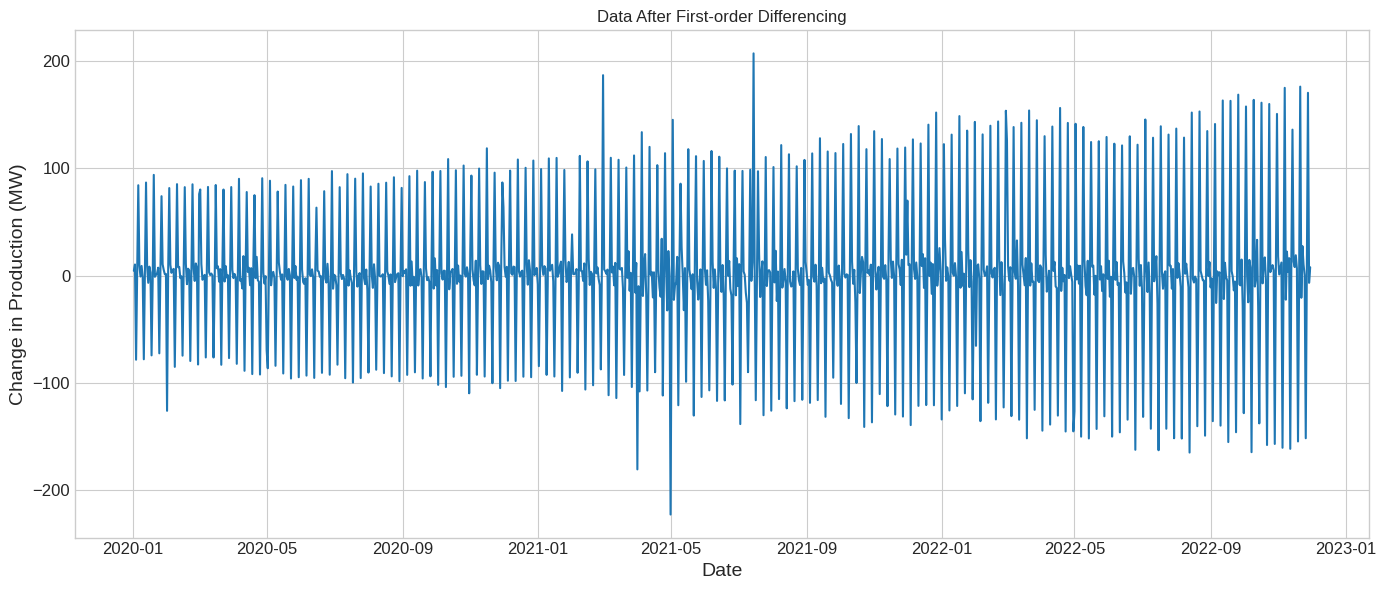


### 4.2 ACF and PACF Analysis

Analyzing ACF and PACF of original data:


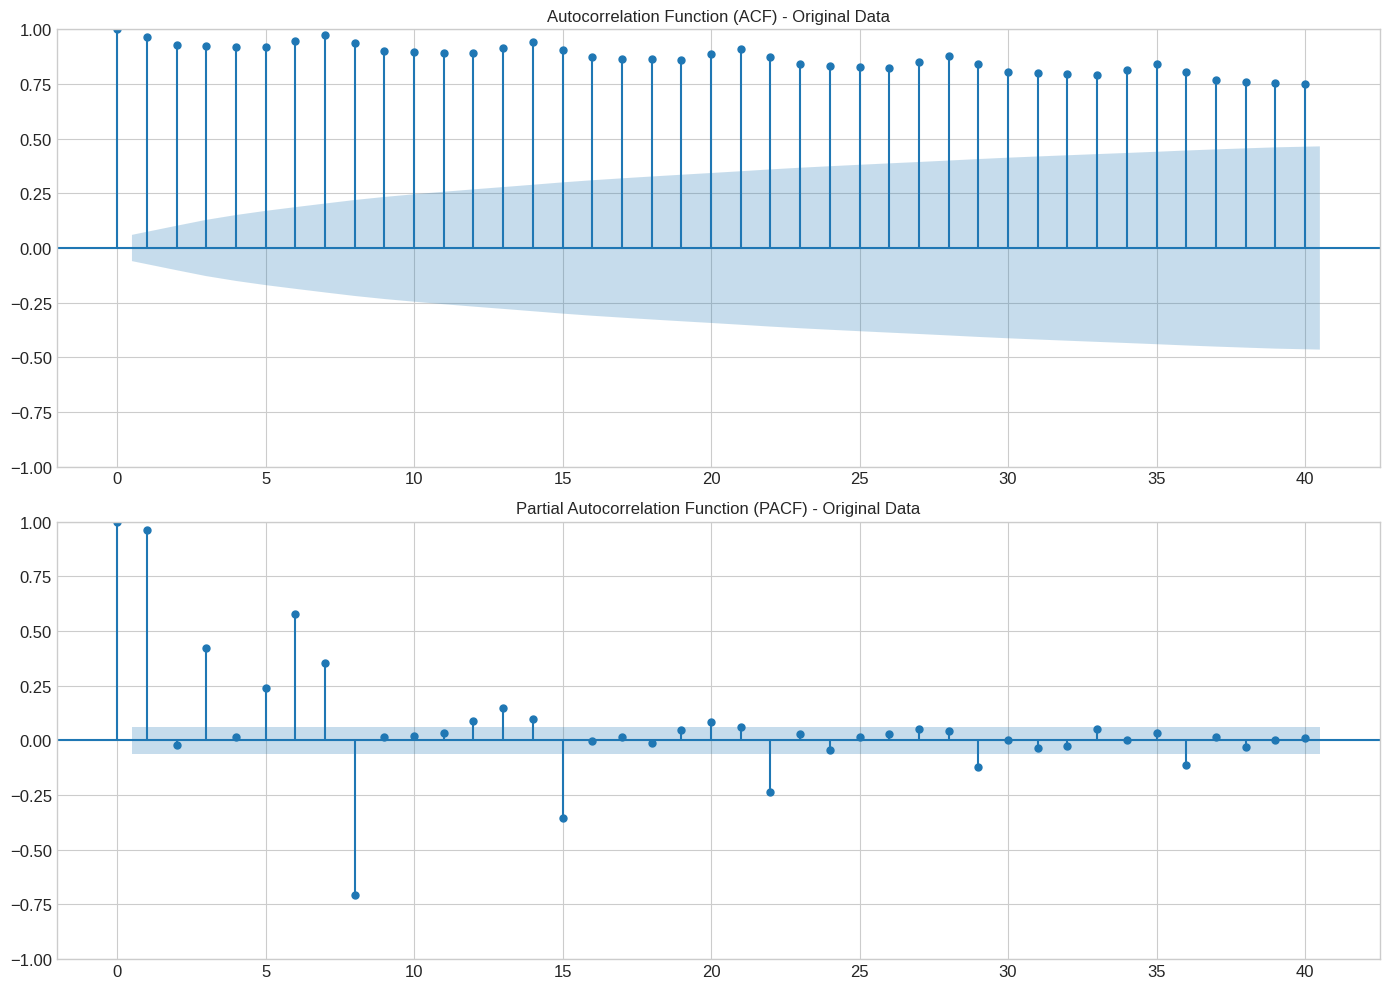


Analyzing ACF and PACF of data after First-order Differencing:


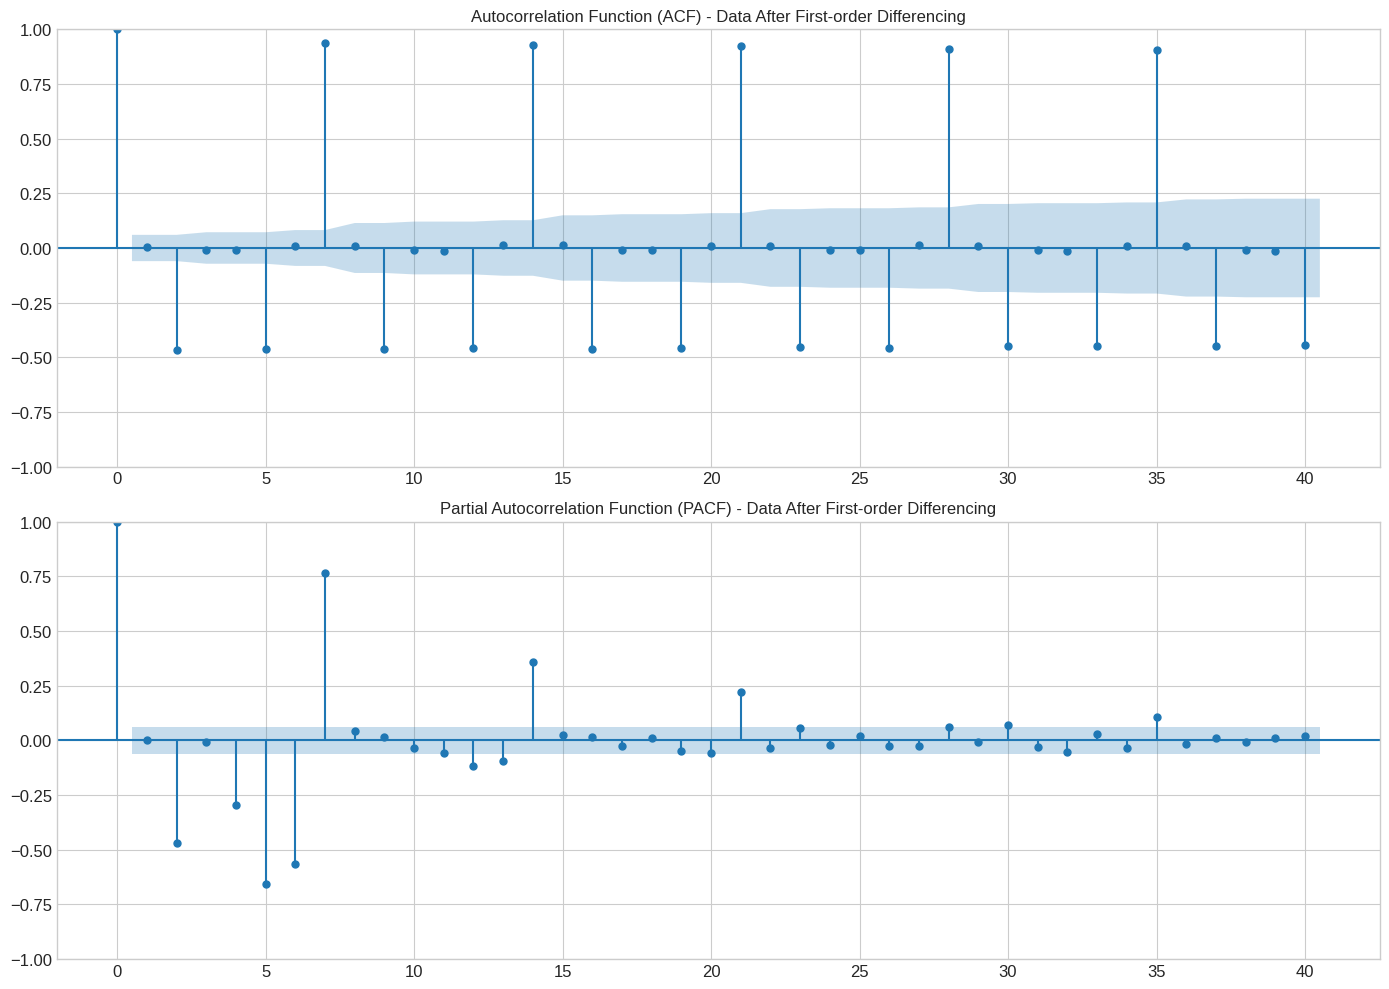


### 4.3 Parameter Selection for ARIMA Model

Selecting parameters p, d, q for ARIMA(p,d,q):
- p: Number of significant lags in PACF (AR term)
- d: Number of differencing operations (0 if data is stationary, 1 if first-order differencing)
- q: Number of significant lags in ACF after considering AR term (MA term)

From ACF and PACF analysis:
Data is non-stationary, need first-order differencing, so d = 1
Looking at PACF of differenced data, there is significant lag at 1, so we might choose p = 1
Looking at ACF of differenced data, there is significant lag at 1, so we might choose q = 1
Therefore, we might use ARIMA(1,1,1)

### 4.4 Building ARIMA Model with Selected Parameters
Building ARIMA(1,1,1)

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:           power_output   No. Observations:                 1065
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5840.048
Date:                Tue, 15 Apr 20

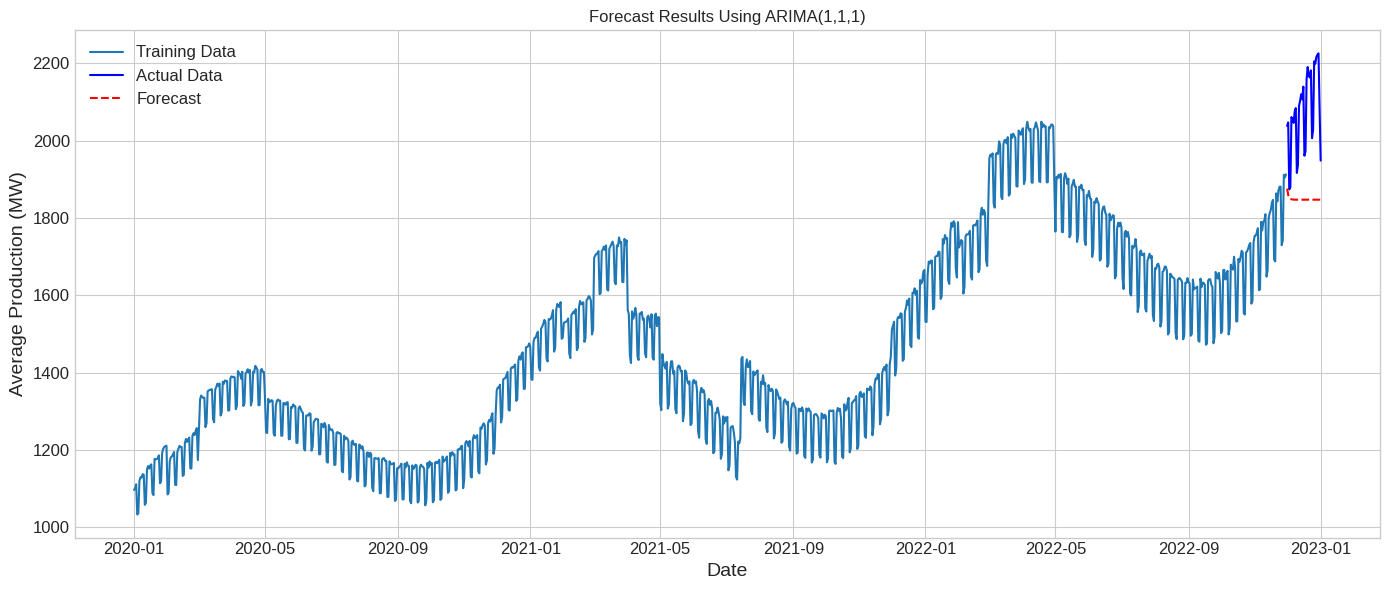


Model Evaluation Results for ARIMA(1,1,1):
MAE: 229.29 MW
RMSE: 250.96 MW
MAPE: 10.82%

### 4.5 Using Manual Auto-ARIMA to Find the Best Parameters
Manual Auto-ARIMA will try various parameter combinations and automatically select the best model

Searching for best parameters using Manual Auto-ARIMA...
Searching for best parameters...
ARIMA(0,0,0) - AIC: 14796.40
ARIMA(0,0,1) - AIC: 13469.48
ARIMA(0,0,2) - AIC: 13134.62
ARIMA(0,1,0) - AIC: 11891.37
ARIMA(0,1,1) - AIC: 11893.24
ARIMA(0,1,2) - AIC: 11444.26
ARIMA(1,0,0) - AIC: 11893.12
ARIMA(1,0,1) - AIC: 11889.49
ARIMA(1,0,2) - AIC: 11462.20
ARIMA(1,1,0) - AIC: 11893.36
ARIMA(1,1,1) - AIC: 11686.10
ARIMA(1,1,2) - AIC: 11429.27
ARIMA(2,0,0) - AIC: 11894.70
ARIMA(2,0,1) - AIC: 11741.30
ARIMA(2,0,2) - AIC: 11447.35
ARIMA(2,1,0) - AIC: 11634.06
ARIMA(2,1,1) - AIC: 11478.90
ARIMA(2,1,2) - AIC: 11431.12

Best model: ARIMA(1, 1, 2) with AIC: 11429.27

Manual Auto-ARIMA Model Summary:
                               SARIMAX Results             

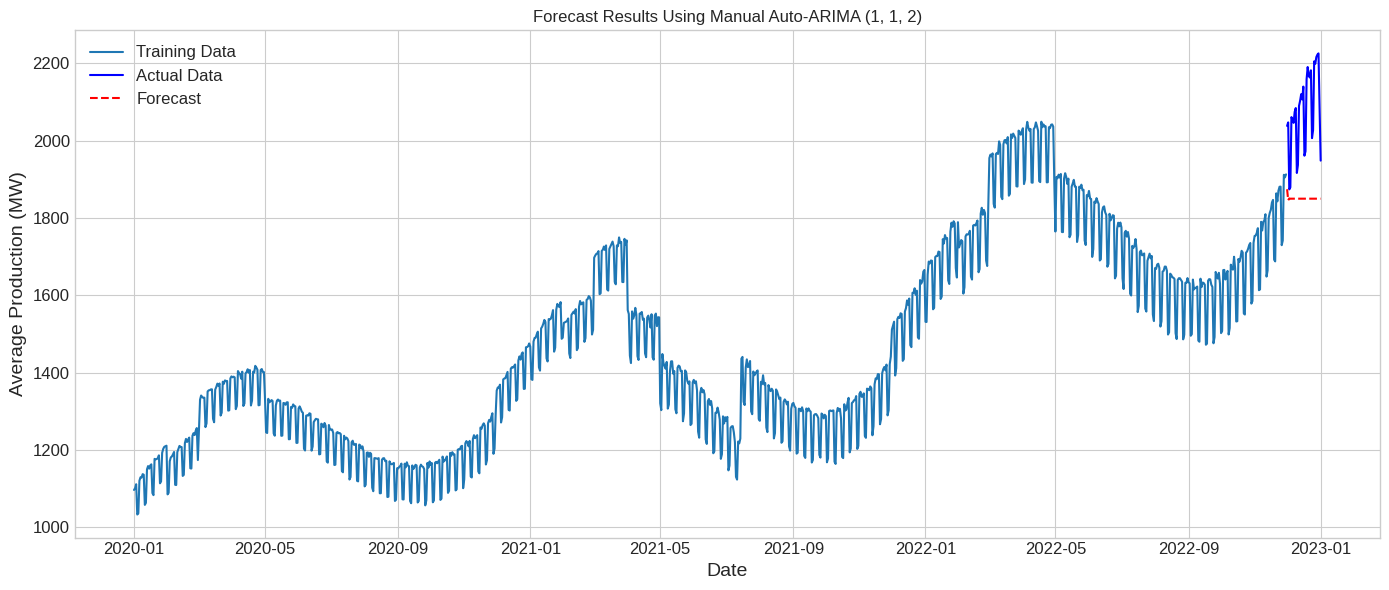


Model Evaluation Results for Manual Auto-ARIMA (1, 1, 2):
MAE: 227.62 MW
RMSE: 249.13 MW
MAPE: 10.74%

### 4.6 Comparing Manual Parameter Selection with Manual Auto-ARIMA

Performance Comparison Table Between Manual Parameter Selection and Manual Auto-ARIMA:
           ARIMA(1, 1, 1)  Manual Auto-ARIMA(1, 1, 2)
MAE (MW)       229.288497                  227.619761
RMSE (MW)      250.956947                  249.134850
MAPE (%)        10.816401                   10.737526


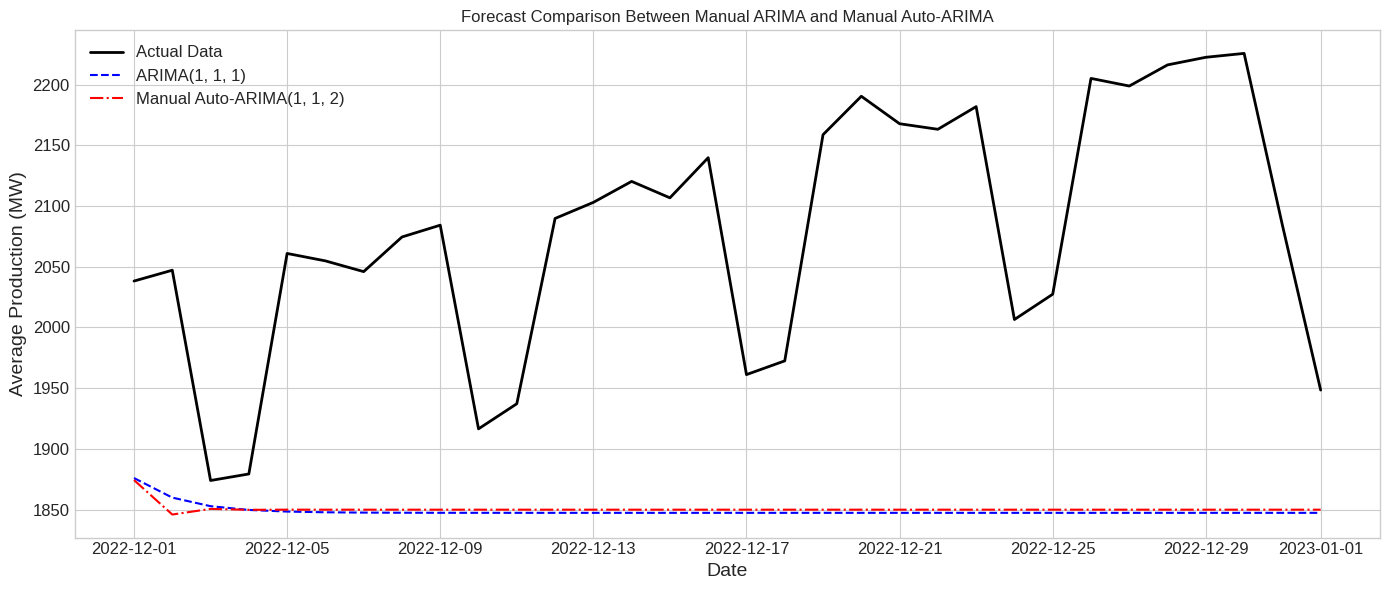

In [5]:
# ---------------------------------------------------------------------------------
# Part 4: ACF and PACF Analysis and Parameter Selection for ARIMA Models
# ---------------------------------------------------------------------------------
print("\n## Part 4: ACF and PACF Analysis and Parameter Selection for ARIMA Models")
print("-" * 50)

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# 4.1 Check data stationarity
print("\n### 4.1 Stationarity Check")

# Function for ADF test
def adf_test(series):
    """Test data stationarity using Augmented Dickey-Fuller test"""
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Data is stationary, suitable for ARIMA modeling")
    else:
        print("Data is non-stationary, may need transformation before using ARIMA models")

    return result[1] <= 0.05  # Return True if data is stationary

# Test stationarity of original data
print("Testing stationarity of original data:")
is_stationary = adf_test(train_data['power_output'])

# If data is non-stationary, transform with differencing
if not is_stationary:
    print("\nApplying First-order differencing to improve stationarity:")
    train_diff = train_data['power_output'].diff().dropna()
    is_diff_stationary = adf_test(train_diff)

    # Display differenced data
    plt.figure(figsize=(14, 6))
    plt.plot(train_data.index[1:], train_diff)
    plt.title('Data After First-order Differencing')
    plt.xlabel('Date')
    plt.ylabel('Change in Production (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4.2 ACF and PACF Analysis
print("\n### 4.2 ACF and PACF Analysis")

# Function to display ACF and PACF
def plot_acf_pacf(series, title='', lags=40):
    """Display ACF and PACF graphs"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # ACF
    plot_acf(series, ax=axes[0], lags=lags)
    axes[0].set_title(f'Autocorrelation Function (ACF) - {title}')
    axes[0].grid(True)

    # PACF
    plot_pacf(series, ax=axes[1], lags=lags)
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {title}')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Analyze ACF and PACF of original data
print("\nAnalyzing ACF and PACF of original data:")
plot_acf_pacf(train_data['power_output'], title='Original Data')

# Analyze ACF and PACF of differenced data
if not is_stationary:
    print("\nAnalyzing ACF and PACF of data after First-order Differencing:")
    plot_acf_pacf(train_diff, title='Data After First-order Differencing')

# 4.3 Parameter selection for ARIMA model
print("\n### 4.3 Parameter Selection for ARIMA Model")
print("\nSelecting parameters p, d, q for ARIMA(p,d,q):")
print("- p: Number of significant lags in PACF (AR term)")
print("- d: Number of differencing operations (0 if data is stationary, 1 if first-order differencing)")
print("- q: Number of significant lags in ACF after considering AR term (MA term)")

# From ACF and PACF analysis above
print("\nFrom ACF and PACF analysis:")
if is_stationary:
    print("Data is stationary, so d = 0")
    print("Looking at PACF, there are significant lags at 1, 2, so we might choose p = 2")
    print("Looking at ACF, there are significant lags at 1, 2, so we might choose q = 2")
    print("Therefore, we might use ARIMA(2,0,2)")

    # Set parameters for ARIMA
    p, d, q = 2, 0, 2
else:
    print("Data is non-stationary, need first-order differencing, so d = 1")
    print("Looking at PACF of differenced data, there is significant lag at 1, so we might choose p = 1")
    print("Looking at ACF of differenced data, there is significant lag at 1, so we might choose q = 1")
    print("Therefore, we might use ARIMA(1,1,1)")

    # Set parameters for ARIMA
    p, d, q = 1, 1, 1

# 4.4 Building ARIMA model with selected parameters
print("\n### 4.4 Building ARIMA Model with Selected Parameters")
print(f"Building ARIMA({p},{d},{q})")

# Build ARIMA model
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_data['power_output'], order=(p, d, q))
arima_fit = arima_model.fit()

# Display model summary
print("\nARIMA Model Summary:")
print(arima_fit.summary())

# Forecast ahead
arima_forecast = arima_fit.forecast(steps=len(test_data))

# Display forecast results
arima_metrics = plot_forecast_results(train_data, test_data, arima_forecast, f"ARIMA({p},{d},{q})")

# 4.5 Using Manual Auto-ARIMA to find the best parameters
print("\n### 4.5 Using Manual Auto-ARIMA to Find the Best Parameters")
print("Manual Auto-ARIMA will try various parameter combinations and automatically select the best model")

# Build Manual Auto-ARIMA model
print("\nSearching for best parameters using Manual Auto-ARIMA...")
auto_arima_model = manual_auto_arima(
    train_data['power_output'],
    seasonal=False,
    start_p=0, start_q=0,
    max_p=2, max_q=2,  # Reduced to 2 to speed up the process
    d=None,
    trace=True
)

# Display Manual Auto-ARIMA model summary
print("\nManual Auto-ARIMA Model Summary:")
print(auto_arima_model.summary())

# Forecast ahead
auto_arima_forecast = auto_arima_model.predict(n_periods=len(test_data))

# Display forecast results
auto_arima_metrics = plot_forecast_results(train_data, test_data, auto_arima_forecast, f"Manual Auto-ARIMA {auto_arima_model.order}")

# 4.6 Compare manual parameter selection with Manual Auto-ARIMA
print("\n### 4.6 Comparing Manual Parameter Selection with Manual Auto-ARIMA")

# Create comparison table
comparison_df = pd.DataFrame({
    f'ARIMA{(p,d,q)}': [arima_metrics['MAE'], arima_metrics['RMSE'], arima_metrics['MAPE']],
    f'Manual Auto-ARIMA{auto_arima_model.order}': [auto_arima_metrics['MAE'], auto_arima_metrics['RMSE'], auto_arima_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nPerformance Comparison Table Between Manual Parameter Selection and Manual Auto-ARIMA:")
print(comparison_df)

# Display forecast comparison graph
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['power_output'], label='Actual Data', color='black', linewidth=2)
plt.plot(test_data.index, arima_forecast, label=f'ARIMA{(p,d,q)}', color='blue', linestyle='--')
plt.plot(test_data.index, auto_arima_forecast, label=f'Manual Auto-ARIMA{auto_arima_model.order}', color='red', linestyle='-.')
plt.title('Forecast Comparison Between Manual ARIMA and Manual Auto-ARIMA')
plt.xlabel('Date')
plt.ylabel('Average Production (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 5: Developing SARIMA Models for Seasonal Data
--------------------------------------------------

### 5.1 Analyzing Seasonality in the Data


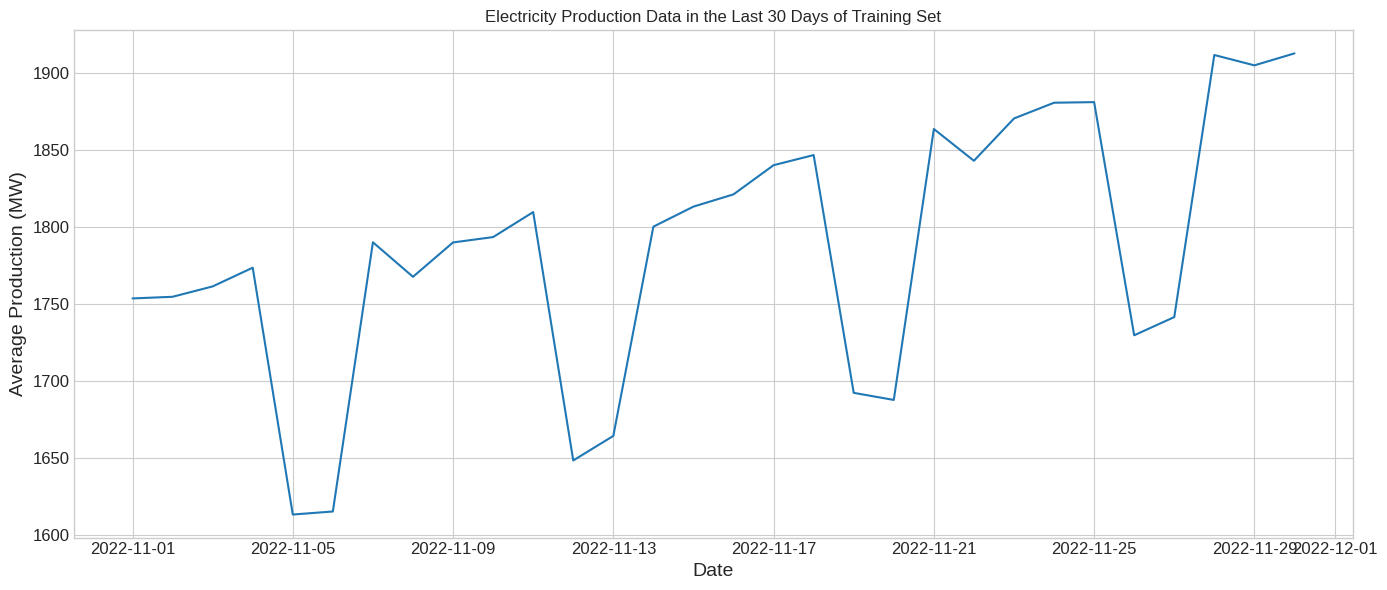

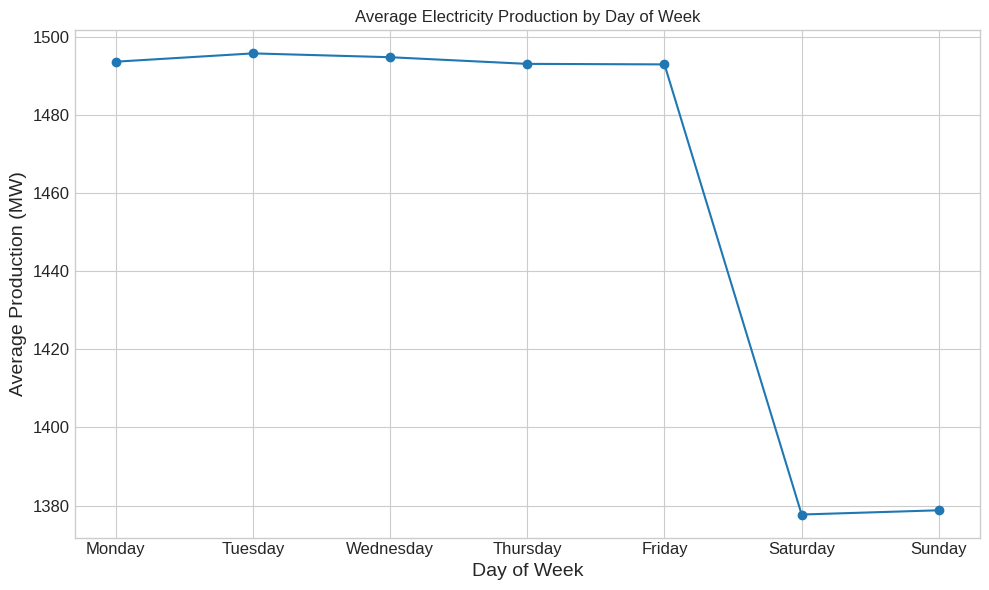


From data analysis, we found:
1. Weekly seasonality (7 days) - lower production on weekends
2. Annual seasonality (365 days), but with only 3 years of data, it's difficult to build an accurate annual seasonal model
3. In this lab, we will focus on SARIMA models considering weekly seasonality

### 5.2 Parameter Selection for SARIMA Model

Selecting parameters for SARIMA(p,d,q)(P,D,Q,s)
- p, d, q: Non-seasonal parameters, similar to ARIMA(p,d,q)
- P: Number of seasonal AR terms
- D: Number of seasonal differencing operations
- Q: Number of seasonal MA terms
- s: Length of seasonality (7 for weekly patterns)

From ACF and PACF analysis of the data:
We selected ARIMA(1,1,1) for the non-seasonal part
For the seasonal part, we might select (1,1,1,7) to capture weekly patterns
Therefore, we choose SARIMA(1,1,1)(1,1,1,7)

### 5.3 Building SARIMA Model with Selected Parameters
Building SARIMA(1,1,1)(1,1,1,7)

SARIMA Model Summary:
                                     SARIMAX Results           

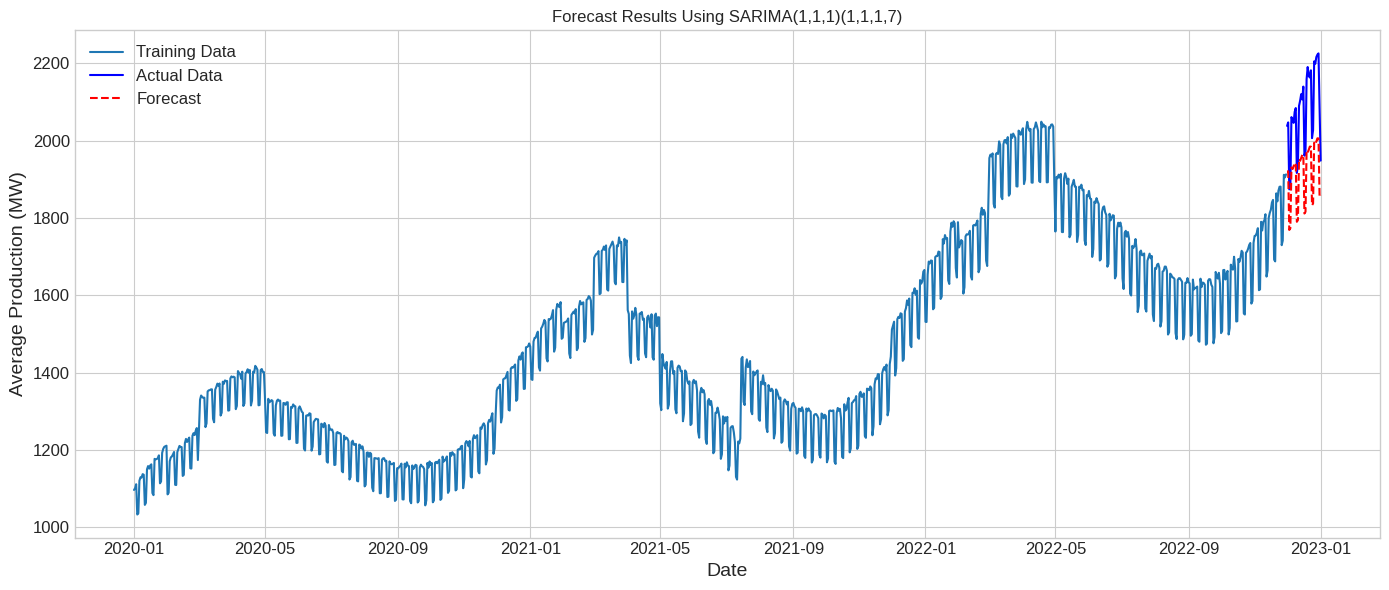


Model Evaluation Results for SARIMA(1,1,1)(1,1,1,7):
MAE: 161.98 MW
RMSE: 166.72 MW
MAPE: 7.74%

### 5.4 Using Seasonal Manual Auto-ARIMA
Seasonal Manual Auto-ARIMA will find the best parameters for both non-seasonal and seasonal parts

Searching for best parameters using Seasonal Manual Auto-ARIMA...
Searching for best parameters...
SARIMA(0,0,0)(0,0,0,7) - AIC: 18576.40
SARIMA(0,0,0)(0,0,1,7) - AIC: 17180.46
SARIMA(0,0,0)(0,1,0,7) - AIC: 10796.46
SARIMA(0,0,0)(0,1,1,7) - AIC: 10773.24
SARIMA(0,0,0)(1,0,0,7) - AIC: 10920.72
SARIMA(0,0,0)(1,0,1,7) - AIC: 10897.52
SARIMA(0,0,0)(1,1,0,7) - AIC: 10763.97
SARIMA(0,0,0)(1,1,1,7) - AIC: 10698.79
SARIMA(0,0,1)(0,0,0,7) - AIC: 17116.62
SARIMA(0,0,1)(0,0,1,7) - AIC: 16087.03
SARIMA(0,0,1)(0,1,0,7) - AIC: 10091.64
SARIMA(0,0,1)(0,1,1,7) - AIC: 10093.54
SARIMA(0,0,1)(1,0,0,7) - AIC: 10233.26
SARIMA(0,0,1)(1,0,1,7) - AIC: 11218.59
SARIMA(0,0,1)(1,1,0,7) - AIC: 10093.50
SARIMA(0,0,1)(1,1,1,7) - AIC: 10061.21
SARIMA(0,0,2)(0,0,0,7) - AIC: 15982.96


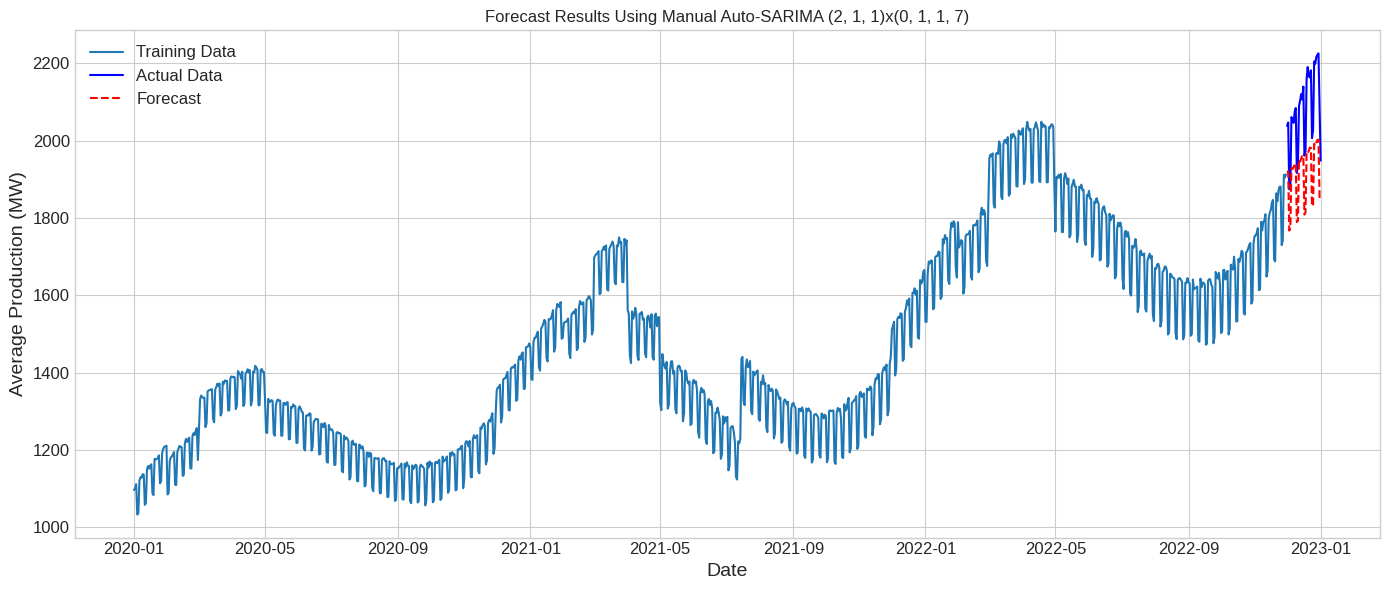


Model Evaluation Results for Manual Auto-SARIMA (2, 1, 1)x(0, 1, 1, 7):
MAE: 164.14 MW
RMSE: 168.99 MW
MAPE: 7.84%

### 5.5 Performance Comparison Between SARIMA and Auto-SARIMA

Performance Comparison Table Between SARIMA and Auto-SARIMA:
           SARIMA(1,1,1)(1,1,1,7)  Auto-SARIMA
MAE (MW)               161.983953   164.144405
RMSE (MW)              166.715662   168.986659
MAPE (%)                 7.741013     7.843947


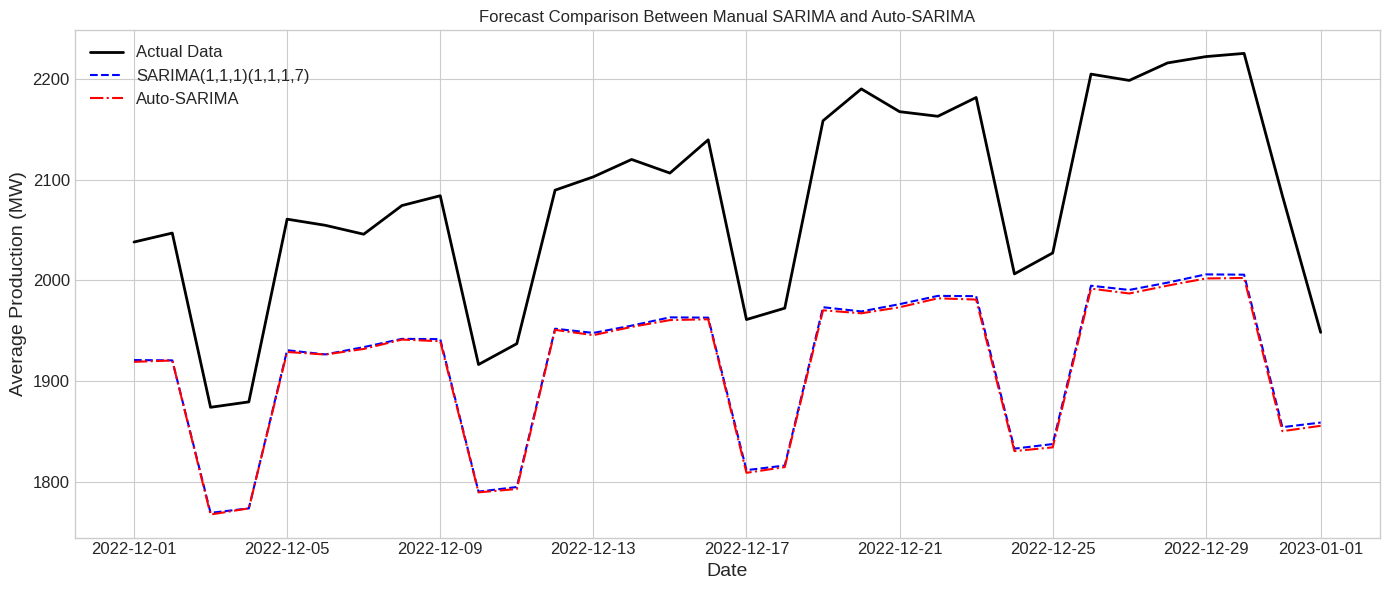

In [6]:
# ---------------------------------------------------------------------------------
# Part 5: Developing SARIMA Models for Seasonal Data
# ---------------------------------------------------------------------------------
print("\n## Part 5: Developing SARIMA Models for Seasonal Data")
print("-" * 50)

# 5.1 Analyzing seasonality in the data
print("\n### 5.1 Analyzing Seasonality in the Data")

# Display graph to observe weekly seasonal patterns
plt.figure(figsize=(14, 6))
plt.plot(train_data.index[-30:], train_data['power_output'][-30:])
plt.title('Electricity Production Data in the Last 30 Days of Training Set')
plt.xlabel('Date')
plt.ylabel('Average Production (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display weekly seasonal averages
def seasonal_plot(data, period, title):
    """Display data by seasonal pattern"""
    season_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    grouped_data = data.groupby(data.index.dayofweek)['power_output'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(grouped_data.index, grouped_data.values, marker='o')
    plt.title(title)
    plt.xlabel('Day of Week')
    plt.ylabel('Average Production (MW)')
    plt.xticks(range(7), season_labels)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

seasonal_plot(train_data, 7, 'Average Electricity Production by Day of Week')

# From data analysis, we found weekly seasonality (7 days) and annual seasonality (365 days)
# But since we have insufficient data for annual seasonality analysis, we focus on weekly seasonality

print("\nFrom data analysis, we found:")
print("1. Weekly seasonality (7 days) - lower production on weekends")
print("2. Annual seasonality (365 days), but with only 3 years of data, it's difficult to build an accurate annual seasonal model")
print("3. In this lab, we will focus on SARIMA models considering weekly seasonality")

# 5.2 Parameter selection for SARIMA model
print("\n### 5.2 Parameter Selection for SARIMA Model")

print("\nSelecting parameters for SARIMA(p,d,q)(P,D,Q,s)")
print("- p, d, q: Non-seasonal parameters, similar to ARIMA(p,d,q)")
print("- P: Number of seasonal AR terms")
print("- D: Number of seasonal differencing operations")
print("- Q: Number of seasonal MA terms")
print("- s: Length of seasonality (7 for weekly patterns)")

print("\nFrom ACF and PACF analysis of the data:")
print(f"We selected ARIMA({p},{d},{q}) for the non-seasonal part")
print("For the seasonal part, we might select (1,1,1,7) to capture weekly patterns")
print(f"Therefore, we choose SARIMA({p},{d},{q})(1,1,1,7)")

# 5.3 Building SARIMA model with selected parameters
print("\n### 5.3 Building SARIMA Model with Selected Parameters")
print(f"Building SARIMA({p},{d},{q})(1,1,1,7)")

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build SARIMA model
sarima_model = SARIMAX(
    train_data['power_output'],
    order=(p, d, q),
    seasonal_order=(1, 1, 1, 7)
)
sarima_fit = sarima_model.fit(disp=False)

# Display model summary
print("\nSARIMA Model Summary:")
print(sarima_fit.summary())

# Forecast ahead
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

# Display forecast results
sarima_metrics = plot_forecast_results(train_data, test_data, sarima_forecast, f"SARIMA({p},{d},{q})(1,1,1,7)")

# 5.4 Using Manual Auto-ARIMA with seasonality
print("\n### 5.4 Using Seasonal Manual Auto-ARIMA")
print("Seasonal Manual Auto-ARIMA will find the best parameters for both non-seasonal and seasonal parts")

# Build Seasonal Manual Auto-ARIMA model
print("\nSearching for best parameters using Seasonal Manual Auto-ARIMA...")
seasonal_auto_arima_model = manual_auto_arima(
    train_data['power_output'],
    seasonal=True,
    m=7,  # Length of seasonality (7 days)
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    d=None, D=None,
    trace=True
)

# Display Seasonal Manual Auto-ARIMA model summary
print("\nSeasonal Manual Auto-ARIMA Model Summary:")
print(seasonal_auto_arima_model.summary())

# Forecast ahead
seasonal_auto_arima_forecast = seasonal_auto_arima_model.predict(n_periods=len(test_data))

# Display forecast results
seasonal_auto_arima_metrics = plot_forecast_results(
    train_data,
    test_data,
    seasonal_auto_arima_forecast,
    f"Manual Auto-SARIMA {seasonal_auto_arima_model.order}x{seasonal_auto_arima_model.seasonal_order}"
)

# 5.5 Compare performance between SARIMA and Auto-SARIMA
print("\n### 5.5 Performance Comparison Between SARIMA and Auto-SARIMA")

# Create comparison table
comparison_df = pd.DataFrame({
    f'SARIMA({p},{d},{q})(1,1,1,7)': [sarima_metrics['MAE'], sarima_metrics['RMSE'], sarima_metrics['MAPE']],
    f'Auto-SARIMA': [seasonal_auto_arima_metrics['MAE'], seasonal_auto_arima_metrics['RMSE'], seasonal_auto_arima_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nPerformance Comparison Table Between SARIMA and Auto-SARIMA:")
print(comparison_df)

# Display forecast comparison graph
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['power_output'], label='Actual Data', color='black', linewidth=2)
plt.plot(test_data.index, sarima_forecast, label=f'SARIMA({p},{d},{q})(1,1,1,7)', color='blue', linestyle='--')
plt.plot(test_data.index, seasonal_auto_arima_forecast, label='Auto-SARIMA', color='red', linestyle='-.')
plt.title('Forecast Comparison Between Manual SARIMA and Auto-SARIMA')
plt.xlabel('Date')
plt.ylabel('Average Production (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 6: Performance Comparison of All Models and Conclusion
--------------------------------------------------

### 6.1 Performance Comparison of All Models

Performance Comparison Table of All Models:
           Simple Exp. Smoothing  Holt Exp. Smoothing  Holt-Winters (Weekly)  \
MAE (MW)              180.191149           108.186324             119.378856   
RMSE (MW)             203.855670           145.141527             122.076245   
MAPE (%)                8.465903             5.304502               5.722895   

           ARIMA(1,1,1)  Auto-ARIMA  SARIMA(1,1,1)(1,1,1,7)  Auto-SARIMA  
MAE (MW)     229.288497  227.619761              161.983953   164.144405  
RMSE (MW)    250.956947  249.134850              166.715662   168.986659  
MAPE (%)      10.816401   10.737526                7.741013     7.843947  


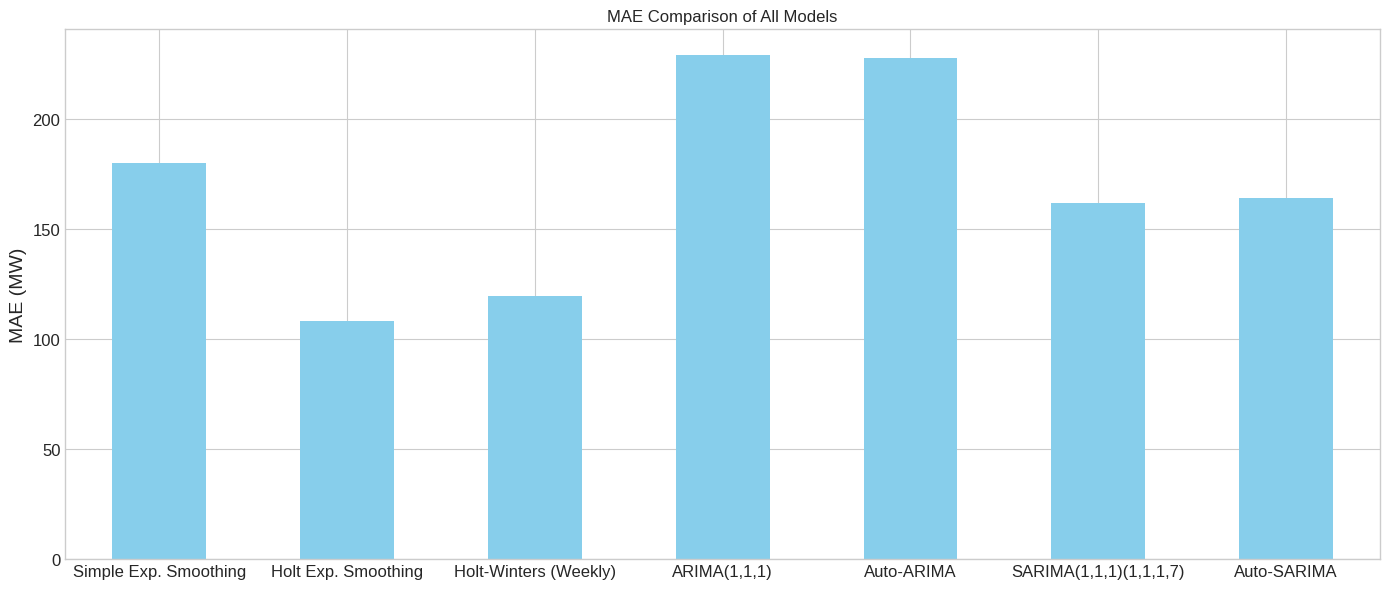

In [7]:
# ---------------------------------------------------------------------------------
# Part 6: Compare Performance of All Models and Conclude
# ---------------------------------------------------------------------------------
print("\n## Part 6: Performance Comparison of All Models and Conclusion")
print("-" * 50)

# 6.1 Compare performance of all models
print("\n### 6.1 Performance Comparison of All Models")

# Create comparison table for all models
all_models_comparison = pd.DataFrame({
    'Simple Exp. Smoothing': [ses_metrics['MAE'], ses_metrics['RMSE'], ses_metrics['MAPE']],
    'Holt Exp. Smoothing': [holt_metrics['MAE'], holt_metrics['RMSE'], holt_metrics['MAPE']],
    'Holt-Winters (Weekly)': [hw_metrics['MAE'], hw_metrics['RMSE'], hw_metrics['MAPE']],
    f'ARIMA({p},{d},{q})': [arima_metrics['MAE'], arima_metrics['RMSE'], arima_metrics['MAPE']],
    'Auto-ARIMA': [auto_arima_metrics['MAE'], auto_arima_metrics['RMSE'], auto_arima_metrics['MAPE']],
    f'SARIMA({p},{d},{q})(1,1,1,7)': [sarima_metrics['MAE'], sarima_metrics['RMSE'], sarima_metrics['MAPE']],
    'Auto-SARIMA': [seasonal_auto_arima_metrics['MAE'], seasonal_auto_arima_metrics['RMSE'], seasonal_auto_arima_metrics['MAPE']],
}, index=['MAE (MW)', 'RMSE (MW)', 'MAPE (%)'])

print("\nPerformance Comparison Table of All Models:")
print(all_models_comparison)

# Create bar chart comparing MAE
plt.figure(figsize=(14, 6))
all_models_comparison.loc['MAE (MW)'].plot(kind='bar', color='skyblue')
plt.title('MAE Comparison of All Models')
plt.ylabel('MAE (MW)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()